### 03_financial_ratios_credit_scoring.ipynb

**Purpose:** merged cleaned data, compute finacial ratios, create sector-aware normalized metrics, build  a weighted credit score, map to rate bands and export results for power BI.

**Visuals:** correlation heatmap, sector boxplots, rating distribution, DE vs ROA scatter.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

In [6]:
# Data path
 DATA_PATH = Path(r"C:/Users/.../clean_data")

# quick check
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Clean data folder not found: {DATA_PATH}")


In [7]:
# Sector Map
sector_csv = DATA_PATH / "sector_map.CSV"
if not sector_csv.exists():
    sector_text = """ticker, sector
RELIANCE.NS,Energy & Petrochemicals
TCS.NS,IT Services
INFY.NS,IT Services
HDFCBANK.NS,Banking
ICICIBANK.NS,Banking
SBIN.NS,Banking
ITC.NS,FMCG & Tobacco
ADANIPORTS.NS,Ports & Infrastructure
LT.NS,Capital Goods / Engineering
BAJFINANCE.NS,Non-Banking Financial Company (NBFC)
"""
    sector_csv.write_text(sector_text)
    print("Created sector_map.csv at",sector_csv)
else:
    print("sector_map.csv already exist at", sector_csv)

sector_map.csv already exist at C:\Users\amalm\OneDrive\Desktop\finamcial_data_analysis_lerning\project\Credit Risk Analysis Rating Simulation\clean_data\sector_map.CSV


In [8]:
# Loading cleaned CSV s
income = pd.read_csv(DATA_PATH /"clean_income.csv")
balance = pd.read_csv(DATA_PATH /"clean_balance.csv")
cashflow = pd.read_csv(DATA_PATH /"clean_cashflow.csv")
eps = pd.read_csv(DATA_PATH /"clean_eps.csv")

# Loading sector map CSV (external file)
sector_map = pd.read_csv(DATA_PATH / "sector_map.csv")

print("Rows (income, balance, cashflow, eps):", len(income), len(balance), len(cashflow), len(eps))
print("Sector map rows:", len(sector_map))


Rows (income, balance, cashflow, eps): 30 30 33 85
Sector map rows: 10


In [9]:
# Merge income + balance + cashflow with inner join
df = income.merge( balance, on =["ticker","year"], how ="inner", suffixes = ('_inc','_bs'))
df = df.merge( cashflow, on =["ticker","year"], how ="inner", suffixes=('','_cs'))

# merge eps (left)
df = df.merge(eps[['ticker','year','eps_basic']], on=["ticker","year"], how="left")
# attaching sector via CSV map
sector_map.columns = sector_map.columns.str.strip()
df = df.merge(sector_map, on="ticker", how="left")
df['sector'] = df['sector'].fillna("Unknown")

print("Merged rows (after inner join):", len(df))
display(df[['ticker','year','sector']].drop_duplicates().head())

Merged rows (after inner join): 80


,ticker,year,sector
0,ADANIPORTS.NS,2022,Ports & Infrastructure
1,ADANIPORTS.NS,2023,Ports & Infrastructure
4,ADANIPORTS.NS,2024,Ports & Infrastructure
8,BAJFINANCE.NS,2022,Non-Banking Financial Company (NBFC)
9,BAJFINANCE.NS,2023,Non-Banking Financial Company (NBFC)


## Computing ratios
### we are calculating Profitability, Leverage & Liquidity, Interest coverage, Cash flow ratios, Efficiency

In [10]:
# Profitability
df['net_margin'] =df['net_income']/df['revenue'].replace(0,np.nan)
df['roa'] = df['net_income']/df['total_assets'].replace(0,np.nan)
df['roe'] = df['net_income']/df['equity'].replace(0,np.nan)

In [11]:
# Leverage & Liquidity
df['debt_to_equity'] = np.where(
    df['equity'] > 0,
    df['total_liabilities'] / df['equity'],
    np.nan
)

# Current Ratio (fallback proxy)
df['current_ratio'] = np.where(
    df['total_liabilities'].notna() & df['current_assets'].notna() & (df['total_liabilities'] > 0),
    df['current_assets']/df['total_liabilities'],
    np.nan
)

# Operating Cash Flow and Total Liabilities ratio
df['ocf_liabilities_ratio'] = np.where(
    df['operating_cashflow'].notna() & df['total_liabilities'].notna() & (df['total_liabilities'] > 0),
    df['operating_cashflow']/ df['total_liabilities'],
    np.nan
)


* Because Yahoo finance does not provide Current Liabilities consistently for Indian equities via the API, we use Total Liabilities as a fallback proxy for liquidity. It is not a perfect liquidity indicator but it gives a directional estimate of short-term repayment ability.
  
* Operating Cash Flow ÷ Total Liabilities tells whether the business generates enough real cash to service its debt.

In [12]:
# intrest coverage ratio 
df['interest_coverage'] = np.where(
    df['operating_income'].notna() & df['operating_cashflow'].replace(0,np.nan).notna(),
    df['operating_income']/ df['operating_cashflow'].abs(),
    np.nan
    )
   

* Usaully interest coverage is calculated with income expense and operating income. Since we does'nt have income expense, we are using operating cashflow as a fallback proxy 

In [13]:
 # Asset_turnover
df['asset_turnover'] = np.where(
    df['revenue'].notna() & df['total_assets'].replace(0,np.nan).notna(),
    df['revenue']/ df['total_assets'],
    np.nan
    )
   

In [14]:
# Free Cashflow Ratio
df['free_cashflow'] = df['operating_cashflow'] - df['capex']
df['fcf_ratio'] = np.where(
    df['free_cashflow'].notna() & df['total_liabilities'].replace(0,np.nan).notna(),
    df['free_cashflow']/ df['total_liabilities'],
    np.nan
    )


* Free Cash Flow represents the cash available after accounting for capital expenditures required to maintain operations.
* The Free Cash Flow to Total Liabilities ratio evaluates a firm’s ability to service its obligations using internally generated cash, making it a strong indicator of solvency and financial resilience.
* In cases where capital expenditure data is unavailable, operating cash flow is used as a proxy and clearly labeled as such.

In [15]:
# Checking ratio for vaid count 
ratio_columns = [
    'net_margin', 'roa', 'roe','debt_to_equity',
    'current_ratio','interest_coverage', 'asset_turnover'
]
valid_count = df[ratio_columns].notna().sum().to_frame(name = 'valid_count')
valid_count

,valid_count
net_margin,80
roa,80
roe,80
debt_to_equity,80
current_ratio,49
interest_coverage,49
asset_turnover,80


## Normalization

Different ratios have different scales. To combine them into one composite score we:

1. Min-max normalize each ratio across the dataset: `(x - min)/(max - min)` -> 0..1
2. For ratios where *lower* is better (e.g., Debt-to-Equity), invert: `1 - normalized_value`
3. If ratio has no variation or NaNs across dataset, normalized column will be NaN.

In [16]:
ratio_columns = [c for c in ratio_columns if c in df.columns]  # Only keeping ratio that exists in main df 
norm = pd.DataFrame(index = df.index)   # Creating an data frame to keep norm values

for c in ratio_columns:
    s = df[c].astype(float)
    minv = s.min(skipna = True)
    maxv = s.max(skipna = True)
    if pd.isna(minv) or pd.isna(maxv) or minv == maxv: 
        norm[c+ '_norm'] = np.nan
    else:
        scaled = (s-minv)/(maxv - minv)
        if c == 'debt_to_equity':
            scaled = 1- scaled   # Lower is better hence inverted
        norm[c+ '_norm'] = scaled.clip(0,1)

# attach normalized columns
for col in norm.columns:
    df[col] = norm[col]

display(df[[c + '_norm' for c in ratio_columns]].head())
    

,net_margin_norm,roa_norm,roe_norm,debt_to_equity_norm,current_ratio_norm,interest_coverage_norm,asset_turnover_norm
0,0.625473,0.138218,0.108192,0.928263,0.025968,0.016789,0.078887
1,0.536077,0.129240,0.103280,0.922277,0.000000,0.142583,0.085989
2,0.536077,0.129240,0.103280,0.922277,0.000000,0.142583,0.085989
3,0.536077,0.129240,0.103280,0.922277,0.000000,0.142583,0.085989
4,0.668275,0.200750,0.185104,0.939213,0.005562,0.157171,0.112799


## Sector Z Score

 

In [17]:
# Convert sector z-score to 0..1 by clipping z in [-3,3] and mapping -> (z+3)/6

def z_to_0_1(z):
    z = z.astype(float)
    zc = (z.clip(-3,3) + 3)/6.0
    return zc

for c in ratio_columns:
    if c in df.columns:
        df[c+'_Z'] = df.groupby('sector')[c].transform(lambda x: (x - x.mean())/x.std(ddof =0) if x.std(ddof = 0) !=0 else np.nan)
        df[c +'_sector'] = z_to_0_1(df[c+'_Z'])
                                


## Final Normalization

In [18]:
alpha = 0.7 # 70% global,30% sector

for c in ratio_columns:
    g = c + '_norm'
    s = c +'_sector'
    f = c +'_final'
    if g in df.columns and s in df.columns:
        df[f] = alpha*df[g]  + (1-alpha)*df[s]
    elif g in df.columns:
        df[f] = df[g]
    elif s in df.columns:
        df[f] = df[s]
    else:
        df[f] = np.nan

for c in [c for c in df.columns if c.endswith('_final')]:
    df[c] =df[c].clip(0,1)
        

## Weighted composite credit score

In [19]:
# Weighted Credit Score
weights = {
    'roa_final': 0.15,
    'net_margin_final': 0.15,
    'asset_turnover_final': 0.10,
    'interest_coverage_final': 0.25,
    'debt_to_equity_final': 0.20,
    'current_ratio_final': 0.15
}

# keep only ratios that exist in the dataframe
valid_weights ={k:v for k,v in weights.items() if k in df.columns}

# weighted average (row-wise), ignoring missing values

df['credit_score_raw'] = (
    df[list(valid_weights.keys())]
    .mul(list(valid_weights.values()))
    .sum(axis =1)
)

# scaling to 0–100

df['credit_score'] = df['credit_score_raw']*100
    

## Score to Rating 

In [20]:
def score_to_rating(s):
    if pd.isna(s) : return np.nan
    if s >= 80: return 'AAA'
    if s >= 70: return 'AA'
    if s >= 60: return 'A'
    if s >= 50: return 'BBB'
    if s >= 40: return 'BB'
    if s >= 30: return 'B'
    return 'CCC'

df['credit_rating'] = df['credit_score'].apply(score_to_rating)

print("Rating counts:")
print(df['credit_rating'].value_counts(dropna=False))



Rating counts:
credit_rating
CCC    24
B      19
AA     17
BB     11
BBB     5
A       4
Name: count, dtype: int64


### correlation heatmap

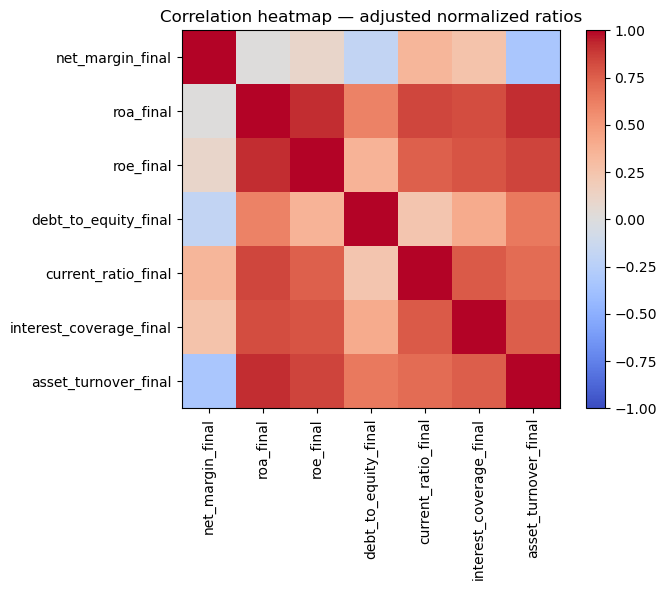

In [21]:
# correlation heatmap for the raw numeric ratios (final ratio)

plot_cols = [c for c in df.columns if c.endswith('_final')]

if len(plot_cols) >= 2:
    corr = df[plot_cols].astype(float).corr()

    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(range(len(plot_cols)), plot_cols, rotation=90)
    plt.yticks(range(len(plot_cols)), plot_cols)

    plt.title("Correlation heatmap — adjusted normalized ratios")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough ratio columns to plot heatmap.")


The correlation heatmap shows profitability metrics (ROA, ROE, margin) are highly correlated, while leverage and liquidity add independent information. This validates the multi-factor structure of the model and avoids double counting.

### Sector-level boxplots of credit_score

C:\Users\amalm\AppData\Local\Temp\ipykernel_24784\2070209551.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sectors, showfliers=True)


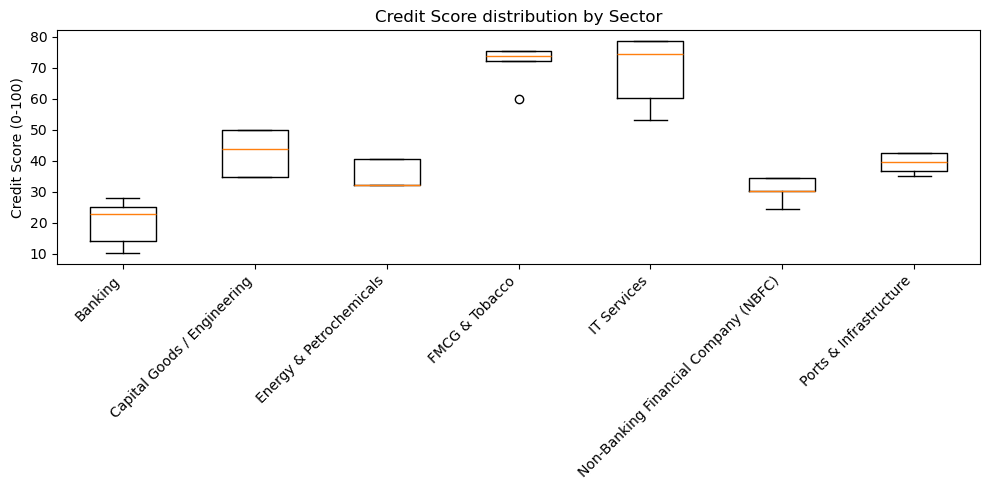

In [22]:
# boxplot of credit_score by sector
grouped = df.dropna(subset=['credit_score']).groupby('sector')['credit_score'].apply(list)
sectors = list(grouped.index)
if len(sectors) > 0:
    data = grouped.values
    plt.figure(figsize=(10,5))
    plt.boxplot(data, labels=sectors, showfliers=True)
    plt.xticks(rotation=45, ha='right')
    plt.title("Credit Score distribution by Sector")
    plt.ylabel("Credit Score (0-100)")
    plt.tight_layout()
    plt.show()
else:
    print("No sector credit scores to plot.")

The boxplot analysis highlights clear sectoral differences in credit quality. IT Services and FMCG exhibit higher and more stable credit scores, indicating defensive and asset-light business models. Energy and NBFCs show wider dispersion and lower medians, reflecting cyclicality and leverage risk. Banking displays heterogeneous credit profiles due to variation in asset quality and capitalization across institutions.”

### Rating distribution

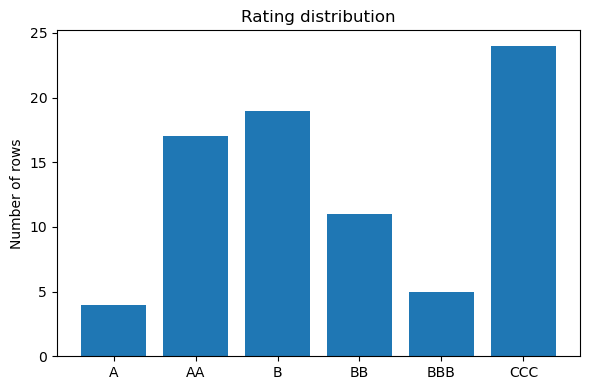

In [23]:
counts = df['credit_rating'].value_counts(dropna=True).sort_index()
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Rating distribution")
plt.ylabel("Number of rows")
plt.tight_layout()
plt.show()

### Scatter D/E vs ROA

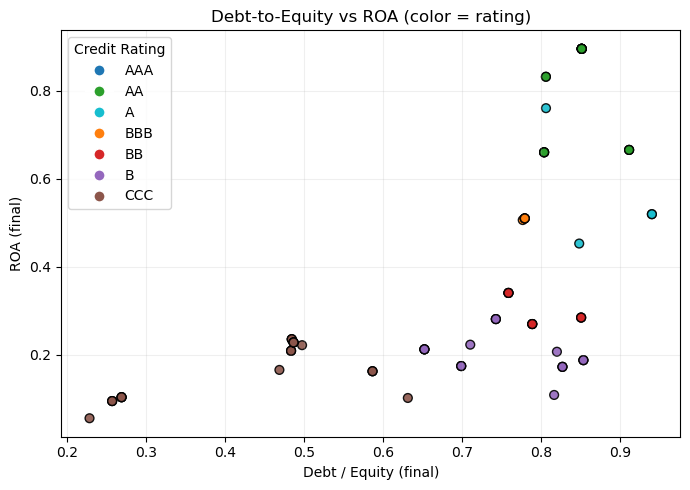

In [26]:
# scatter of debt_to_equity vs roa, colored by rating
if 'debt_to_equity_final' in df.columns and 'roa_final' in df.columns:
    # map ratings to colors
    rating_colors = {
        'AAA':'#1f77b4','AA':'#2ca02c','A':'#17becf',
        'BBB':'#ff7f0e','BB':'#d62728','B':'#9467bd','CCC':'#8c564b'
    }
    colors = df['credit_rating'].map(rating_colors).fillna('#7f7f7f')
    plt.figure(figsize=(7,5))
    plt.scatter(df['debt_to_equity_final'], df['roa_final'], c=colors, s=40, alpha=0.9, edgecolor='k')
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AAA',
           markerfacecolor='#1f77b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='AA',
           markerfacecolor='#2ca02c', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='A',
           markerfacecolor='#17becf', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='BBB',
           markerfacecolor='#ff7f0e', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='BB',
           markerfacecolor='#d62728', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='B',
           markerfacecolor='#9467bd', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='CCC',
           markerfacecolor='#8c564b', markersize=8),
    ]
    plt.legend(handles=legend_elements, title="Credit Rating")

    plt.xlabel("Debt / Equity (final)")
    plt.ylabel("ROA (final)")
    plt.title("Debt-to-Equity vs ROA (color = rating)")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    print("Need debt_to_equity_final and roa_final to plot scatter.")

The scatter shows that higher credit ratings cluster around stronger ROA, while lower-rated firms exhibit weaker profitability even at comparable leverage levels, validating the credit-risk signal of the adjusted ratios.

In [32]:
# Save final dataset for Power BI
OUT_FILE = DATA_PATH / "final_credit_scores.csv"
df.to_csv(OUT_FILE, index=False)
print("Saved final file to:", OUT_FILE)


Saved final file to: C:\Users\amalm\OneDrive\Desktop\finamcial_data_analysis_lerning\project\Credit Risk Analysis Rating Simulation\clean_data\final_credit_scores.csv


## Short interpretation guidelines

- **credit_score** (0–100): higher = better simulated creditworthiness.
- **credit_rating** maps score bands to AAA to CCC.
- Inspect the **adjusted ratios** (columns `*_final`) to find which drivers push a company's score up or down.

